In [1]:
import data_extract as de
import time
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta

In [2]:
#Setting variables

start_date = '2021-01-01'



In [7]:
#Loading datasets

load_actual_data = de.ACDB().get_ERCOT_load_actuals()[de.ACDB().get_ERCOT_load_actuals()['StartTime'] > start_date]
load_forecast_data = de.ACDB().get_ERCOT_load_forecasts()[de.ACDB().get_ERCOT_load_forecasts()['StartTime'] > start_date]
temp_data = de.ACDB().get_temp_forecasts()[de.ACDB().get_temp_forecasts()['StartTime'] > start_date]
da_data = de.ACDB().get_DAM_hub_spp()[de.ACDB().get_DAM_hub_spp()['StartTime'] > start_date]
rt_data = de.ACDB().get_RT_hub_spp()[de.ACDB().get_RT_hub_spp()['StartTime'] > start_date]
inter_forecast_data = de.ACDB().get_intermittent_forecast()[de.ACDB().get_intermittent_forecast()['StartTime'] > start_date]
inter_actual_data = de.ACDB().get_intermittent_actuals()[de.ACDB().get_intermittent_actuals()['StartTime'] > start_date]
outages_data = de.ACDB().get_total_outages()[de.ACDB().get_total_outages()['StartTime'] > start_date]
ng_data = de.ACDB().get_NGLD1_prices()[de.ACDB().get_NGLD1_prices()['TradeDate'] > start_date]

#Add Heat rate



In [3]:
ng_data = de.ACDB().get_NGLD1_prices()[de.ACDB().get_NGLD1_prices()['TradeDate'] > start_date]

In [4]:
ng_data

,date,strip_date,CurveSource,Market,Lbl,CurveID,TradeDate,Strip,ExpirationDate,SettlementPrice,Hub,Commodity,Contract,ContractType,Exchange,Product
466,2021-01-04,2021-02-01,ICE-NGX,HENRYHUB,Current,229220,2021-01-04,2021-02-01,2021-01-27,2.581,Henry,Gas,H,F,ICE,NG LD1 Futures
467,2021-01-05,2021-02-01,ICE-NGX,HENRYHUB,Current,229220,2021-01-05,2021-02-01,2021-01-27,2.702,Henry,Gas,H,F,ICE,NG LD1 Futures
468,2021-01-06,2021-02-01,ICE-NGX,HENRYHUB,Current,229220,2021-01-06,2021-02-01,2021-01-27,2.716,Henry,Gas,H,F,ICE,NG LD1 Futures
469,2021-01-07,2021-02-01,ICE-NGX,HENRYHUB,Current,229220,2021-01-07,2021-02-01,2021-01-27,2.729,Henry,Gas,H,F,ICE,NG LD1 Futures
470,2021-01-08,2021-02-01,ICE-NGX,HENRYHUB,Current,229220,2021-01-08,2021-02-01,2021-01-27,2.7,Henry,Gas,H,F,ICE,NG LD1 Futures
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,2023-01-17,2023-02-01,ICE-NGX,HENRYHUB,Current,6436,2023-01-17,2023-02-01,2023-01-27,3.586,Henry,Gas,H,F,ICE,NG LD1 Futures
944,2023-01-18,2023-02-01,ICE-NGX,HENRYHUB,Current,6436,2023-01-18,2023-02-01,2023-01-27,3.311,Henry,Gas,H,F,ICE,NG LD1 Futures
945,2023-01-19,2023-02-01,ICE-NGX,HENRYHUB,Current,6436,2023-01-19,2023-02-01,2023-01-27,3.275,Henry,Gas,H,F,ICE,NG LD1 Futures
946,2023-01-20,2023-02-01,ICE-NGX,HENRYHUB,Current,6436,2023-01-20,2023-02-01,2023-01-27,3.174,Henry,Gas,H,F,ICE,NG LD1 Futures


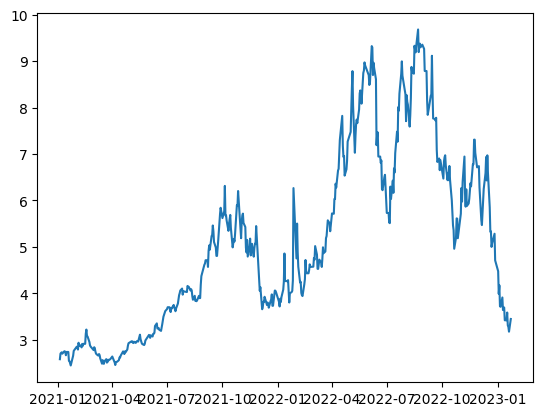

In [5]:
plt.plot(ng_data['TradeDate'],ng_data['SettlementPrice'])
plt.show()